In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

(28, 28)


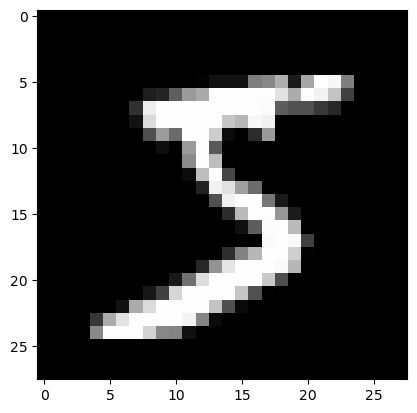

In [2]:
# load the dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='data',
    train=False,
    transform=transform,
    download=True
)

import matplotlib.pyplot as plt

img = train_dataset[0][0].numpy().squeeze()
print(img.shape)
plt.imshow(img, cmap='gray')

In [3]:
img.min(), img.max()

(-1.0, 1.0)

In [4]:
# import torch
# import torch.nn as nn
# from functools import reduce

# class Generator(nn.Module):
#     def __init__(self, final_size=28, num_deconv_layers=3, input_filters=128, output_filters=1, latent_size=100):
#         super().__init__()
#         self.input_filters = input_filters
#         self.num_deconv_layers = num_deconv_layers
#         self.orig_img_size = 4  # Calculate the starting image size
#         self.fc = nn.Linear(latent_size, self.orig_img_size * self.orig_img_size * input_filters, bias=True)
#         self.relu = nn.ReLU()
#         self.bn1d = nn.BatchNorm1d(self.orig_img_size * self.orig_img_size * input_filters)

#         # Define the deconvolutional layers with proper filter reductions
#         deconv_out_filters = reduce(lambda x, _: x + [x[-1] // 2], range(num_deconv_layers), [input_filters])
#         deconv_out_filters[-1] = output_filters  # Set the last filter to match output channels
        
#         # Create deconvolutional layers
#         self.deconv_layers = nn.ModuleDict({
#             f'deconv_{i}': nn.ConvTranspose2d(
#                 in_channels=deconv_out_filters[i], 
#                 out_channels=deconv_out_filters[i + 1], 
#                 stride=2, 
#                 kernel_size=4, 
#                 padding=1
#             ) for i in range(num_deconv_layers)
#         })

#         self.deconv_layers['deconv_2'] = nn.ConvTranspose2d(
#                 in_channels=deconv_out_filters[num_deconv_layers-1], 
#                 out_channels=deconv_out_filters[num_deconv_layers], 
#                 stride=2, 
#                 kernel_size=2, 
#                 padding=2
#             )
        
#         # Add BatchNorm2d for intermediate deconv layers
#         self.bn2d_layers = nn.ModuleDict({
#             f'bn_{i}': nn.BatchNorm2d(deconv_out_filters[i + 1]) for i in range(num_deconv_layers - 1)
#         })
        
#         # Output activation function
#         self.tanh = nn.Tanh()

#     def forward(self, x):
#         # Fully connected layer
#         x = self.relu(self.bn1d(self.fc(x)))
#         # Reshape to start of deconvolutional layers
#         x = x.view(-1, self.input_filters, self.orig_img_size, self.orig_img_size)
        
#         # Deconvolutional layers
#         for idx, deconv in enumerate(list(self.deconv_layers.values())[:-1]):  # Skip last layer
#             x = self.relu(self.bn2d_layers[f'bn_{idx}'](deconv(x)))
        
#         # Final deconvolutional layer without batch norm
#         x = self.tanh(self.deconv_layers[f'deconv_{self.num_deconv_layers - 1}'](x))
#         return x

In [5]:
# from torch.nn.utils import spectral_norm

# class Discriminator(nn.Module):
#     def __init__(self, num_initial_filters=64, num_conv_layers=2, initial_size=28):
#         super().__init__()
#         self.channels = [1] + reduce(lambda x, _: x + [x[-1] * 2], range(num_conv_layers-1), [num_initial_filters])
#         self.conv_layers = nn.ModuleDict({
#             f'conv_{i}': spectral_norm(nn.Conv2d(in_channels=self.channels[i], out_channels=self.channels[i+1], kernel_size=4, stride=2, padding=1))
#             for i in range(num_conv_layers)
#         })
#         self.leaky_relu = nn.LeakyReLU(0.2)
#         self.dropout = nn.Dropout(0.3)
#         self.flatten = nn.Flatten()
#         final_size = initial_size // (2 ** num_conv_layers)
#         self.fc = nn.Linear(final_size * final_size * self.channels[-1], 1)

#     def forward(self, x):
#         for conv in self.conv_layers.values():
#             x = self.dropout(self.leaky_relu(conv(x)))
#         x = self.flatten(x)
#         return self.fc(x)


In [6]:
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),  # Reshape to (128, 7, 7)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, z):
        x = self.fc(z)
        img = self.deconv(x)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1)
        )

    def forward(self, img):
        x = self.conv(img)
        return self.fc(x)


In [ ]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, SubsetRandomSampler, RandomSampler
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import grad
import os

random.seed(42)
torch.manual_seed(42)

class Trainer:
    def __init__(self, exp, k, m, latent_size, train_dataset, debug=False):
        self.exp = exp
        self.k = k
        self.m = m
        self.debug = debug
        self.latent_size = latent_size
        sampler = RandomSampler(train_dataset, replacement=False)
        self.train_dataloader = DataLoader(train_dataset, sampler=sampler, batch_size=m)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.generator = Generator(latent_dim=latent_size).to(self.device)
        self.discriminator = Discriminator().to(self.device)
        self.generator_optim = Adam(self.generator.parameters(), lr=1e-4, betas=(0, 0.9))
        self.discriminator_optim = Adam(self.discriminator.parameters(), lr=1e-4, betas=(0, 0.9))
        self.loss_fn = nn.BCEWithLogitsLoss()

        # Tracking losses and gradients
        self.discriminator_losses = []
        self.generator_losses = []
        self.generator_gradients = []
        self.discriminator_gradients = []
        self.gradient_norms = []
    
    def train(self, iterations):
        data_iterator = iter(self.train_dataloader)
        for itr in tqdm(range(iterations)):
            torch.cuda.empty_cache()

            # Train the discriminator
            total_disc_loss = 0
            for _ in range(self.k):
                try:
                    sample = next(data_iterator)
                except StopIteration:
                    data_iterator = iter(self.train_dataloader)
                    sample = next(data_iterator)
                real_data = sample[0].to(self.device)
                # real_data = real_data + 0.1 * torch.randn_like(real_data)  # Add noise to real data
                noise_samples = torch.randn(real_data.size(0), self.latent_size).to(self.device)
                d_loss = self.train_discriminator(real_data, noise_samples)
                if self.debug:
                    total_disc_loss += d_loss.item()
            
            if self.debug:
                self.discriminator_losses.append(float(total_disc_loss) / self.k)

            # Train the generator
            noise_samples = torch.randn(self.m, self.latent_size).to(self.device)
            g_loss = self.train_generator(noise_samples)
            if self.debug:
                self.generator_losses.append(g_loss.item())

            if self.debug:
                if (itr+1) % 500 == 0:
                    self.save_loss_graphs(directory=f'iteration_{itr}')
                if (itr+1) % 10 == 0:
                    os.makedirs(f'/home/ubuntu/generative-adversarial-networks/notebooks/{self.exp}/{itr}', exist_ok=True)
                    torch.save(self.generator.state_dict(), f'/home/ubuntu/generative-adversarial-networks/notebooks/{self.exp}/{itr}/generator_{itr}.pt')
                    torch.save(self.discriminator.state_dict(), f'/home/ubuntu/generative-adversarial-networks/notebooks/{self.exp}/{itr}/discriminator_{itr}.pt')
                    torch.save(self.generator_optim.state_dict(), f'/home/ubuntu/generative-adversarial-networks/notebooks/{self.exp}/{itr}/generator_optim_{itr}.pt')
                    torch.save(self.discriminator_optim.state_dict(), f'/home/ubuntu/generative-adversarial-networks/notebooks/{self.exp}/{itr}/discriminator_optim_{itr}.pt')

        if self.debug:
            self.save_loss_graphs('final')

    def train_discriminator(self, real_data, noise_samples):
        fake_data = self.generator(noise_samples)
        # fake_data = fake_data + 0.1 * torch.randn_like(fake_data)  # Add noise to fake data
        real_labels = torch.ones(real_data.size(0), 1).to(self.device)
        fake_labels = torch.zeros(fake_data.size(0), 1).to(self.device)

        real_output = self.discriminator(real_data)
        fake_output = self.discriminator(fake_data)

        # real_loss = self.loss_fn(real_output, real_labels)
        # fake_loss = self.loss_fn(fake_output, fake_labels)

        d_loss = -torch.mean(real_output) + torch.mean(fake_output)

        # Gradient penalty calculation
        alpha = torch.rand(real_data.size(0), 1, 1, 1).to(self.device)
        interpolates = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
        disc_interpolates = self.discriminator(interpolates)

        gradients = grad(
            outputs=disc_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(disc_interpolates),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        gradients_norm = gradients.view(gradients.size(0), -1).norm(2, dim=1)
        self.gradient_norms.append(gradients_norm.mean().item())  # Track gradient norm

        lambda_gp = 10
        gp = lambda_gp * ((gradients_norm - 1) ** 2).mean()

        # loss = real_loss + fake_loss + gp
        loss = d_loss + gp

        self.discriminator_optim.zero_grad()
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=10)

        # Track discriminator gradients
        total_grad_norm = 0
        for param in self.discriminator.parameters():
            if param.grad is not None:
                total_grad_norm += param.grad.norm(2).item()
        self.discriminator_gradients.append(total_grad_norm)

        self.discriminator_optim.step()
        
        return loss

    def train_generator(self, noise_samples):
        fake_data = self.generator(noise_samples)
        fake_labels = torch.ones(fake_data.size(0), 1).to(self.device)
        fake_output = self.discriminator(fake_data)

        # loss = self.loss_fn(fake_output, fake_labels)
        loss = -torch.mean(fake_output)
        self.generator_optim.zero_grad()
        loss.backward()

        # Track generator gradients
        total_grad_norm = 0
        for param in self.generator.parameters():
            if param.grad is not None:
                total_grad_norm += param.grad.norm(2).item()
        self.generator_gradients.append(total_grad_norm)

        self.generator_optim.step()
        
        return loss
    
    def save_loss_graphs(self, directory):
        directory = f'/home/ubuntu/generative-adversarial-networks/notebooks/{self.exp}/{directory}'
        os.makedirs(directory, exist_ok=True)

        # Save Discriminator Loss
        plt.figure(figsize=(10, 5))
        plt.plot(self.discriminator_losses, label='Discriminator Loss')
        plt.title('Discriminator Loss Over Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(directory, 'discriminator_loss.png'))
        plt.close()

        # Save Generator Loss
        plt.figure(figsize=(10, 5))
        plt.plot(self.generator_losses, label='Generator Loss')
        plt.title('Generator Loss Over Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(directory, 'generator_loss.png'))
        plt.close()

        # Save Discriminator Gradients
        plt.figure(figsize=(10, 5))
        plt.plot(self.discriminator_gradients, label='Discriminator Gradients')
        plt.title('Discriminator Gradient Norm Over Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Gradient Norm')
        plt.legend()
        plt.savefig(os.path.join(directory, 'discriminator_gradients.png'))
        plt.close()

        # Save Generator Gradients
        plt.figure(figsize=(10, 5))
        plt.plot(self.generator_gradients, label='Generator Gradients')
        plt.title('Generator Gradient Norm Over Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Gradient Norm')
        plt.legend()
        plt.savefig(os.path.join(directory, 'generator_gradients.png'))
        plt.close()

        # Save Gradient Norms
        plt.figure(figsize=(10, 5))
        plt.plot(self.gradient_norms, label='Gradient Norm (Gradient Penalty)')
        plt.title('Gradient Norm Over Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Gradient Norm')
        plt.legend()
        plt.savefig(os.path.join(directory, 'gradient_norm.png'))
        plt.close()

In [8]:
trainer = Trainer('baseline_wasserstein_k5_50k', 5, 128, 100, train_dataset, debug=True)
trainer.train(50000)

  0%|          | 0/50000 [00:00<?, ?it/s]/opt/conda/envs/pytorch/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 189/50000 [00:25<1:52:30,  7.38it/s]


KeyboardInterrupt: 

In [24]:
torch.cat([test_dataset[i][0] for i in range(10)], dim=0).shape

torch.Size([10, 28, 28])

torch.Size([5, 1, 28, 28])
torch.Size([5, 1])
torch.Size([5, 1, 28, 28])
tensor([[ 0.0168],
        [ 1.8493],
        [-0.1552],
        [-0.1046],
        [ 0.7630]], device='cuda:0')
torch.Size([5, 1, 28, 28])
tensor([[2.1613],
        [3.4023],
        [1.0584],
        [2.7215],
        [2.7594]], device='cuda:0')


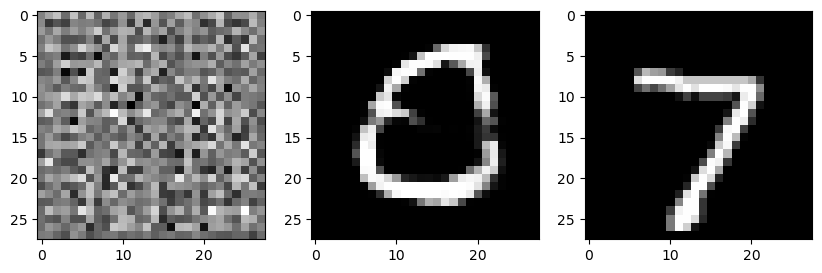

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
latent_size = 100

z = torch.randn(5, latent_size)
with torch.no_grad():
    gen = Generator()
    gen_imgs = gen(z)
    print(gen_imgs.shape)
    disc = Discriminator()
    disc_out = disc(gen_imgs)
    print(disc_out.shape)
    plt.subplot(1, 3, 1)
    plt.imshow(gen_imgs[0].cpu().numpy().squeeze(), cmap='gray')

with torch.no_grad():
    gen_imgs = trainer.generator(z.to(trainer.device))
    plt.subplot(1, 3, 2)
    plt.imshow(gen_imgs[0].cpu().numpy().squeeze(), cmap='gray')
    print(gen_imgs.shape)
    print(trainer.discriminator(gen_imgs))
    real_imgs = torch.stack([test_dataset[i][0] for i in range(5)], dim=0).to(trainer.device)
    plt.subplot(1, 3, 3)
    plt.imshow(real_imgs[0].cpu().numpy().squeeze(), cmap='gray')
    print(real_imgs.shape)
    print(trainer.discriminator(real_imgs))

In [75]:
len(train_dataset[0])

2

In [9]:
train_dataset_size = len(train_dataset)
# print(train_dataset_size)
random_indices = random.sample(range(train_dataset_size), train_dataset_size)
sampler = SubsetRandomSampler(random_indices)
train_dataloader = DataLoader(train_dataset, sampler=sampler, batch_size=100)

In [12]:
sample = next(iter(train_dataloader))
len(sample[0])

100

In [69]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [49]:
z = torch.randn(5, 100)
with torch.no_grad():
    gen = Generator()
    gen_imgs = gen(z)
    print(gen_imgs.shape)
    disc = Discriminator()
    disc_out = disc(gen_imgs)
    print(disc_out.shape)

torch.Size([5, 1, 28, 28])
torch.Size([5, 1])


torch.Size([5, 1, 28, 28])


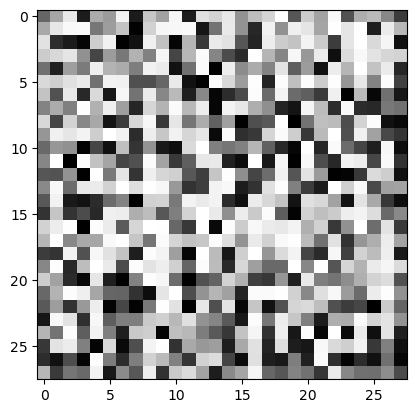

In [8]:
print(gen_imgs.shape)
plt.imshow(gen_imgs[0].squeeze().numpy(), cmap='gray')

torch.Size([5, 784])